In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import tqdm
import geopandas as gpd


In [2]:
zabki_gdf = gpd.read_file('zabki_krakow.geojson')
zabki_gdf = zabki_gdf.to_crs(epsg=4326)
nearest_gdf = gpd.read_file('nearest.geojson')
neares_gdf = nearest_gdf.to_crs(epsg=4326)

import osmnx as ox

G = ox.graph_from_place('Kraków, Poland', network_type='drive')
# Utworzenie GeoDataFrame z ulicami 
streets_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)


(2201466.728842696, 2251903.4973147013, 6440043.130753223, 6468528.844798662)

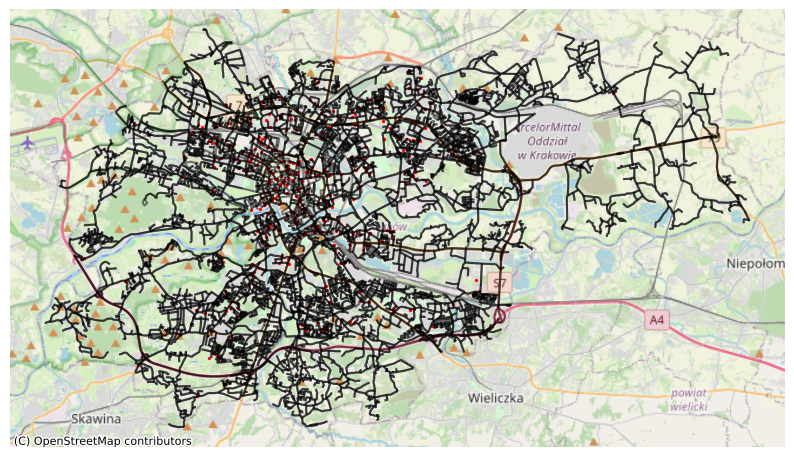

In [3]:
#plot map of Krakow
import contextily as ctx
fig, ax = plt.subplots(figsize=(10, 10))
zabki_gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=0.9, markersize=2)
streets_gdf.to_crs(epsg=3857).plot(ax=ax, color='black', alpha=0.5, markersize=2)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')

Text(0, 0.5, 'Liczba sklepów')

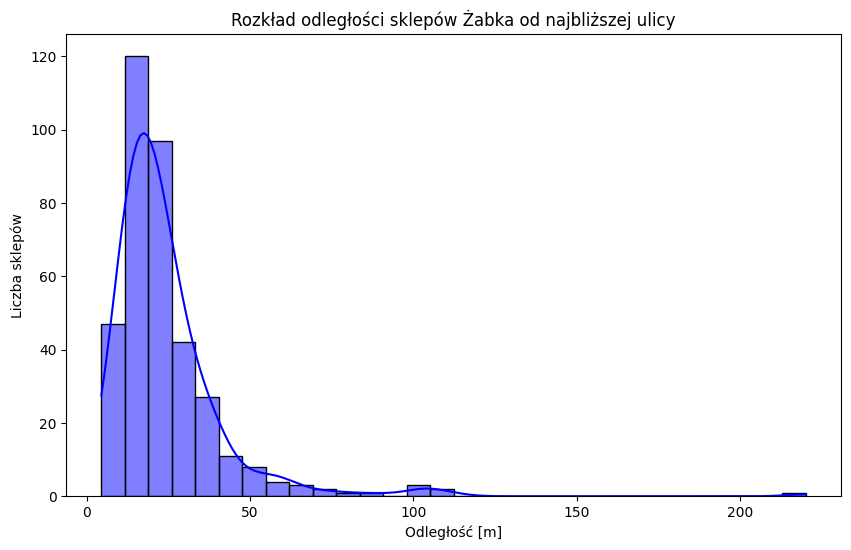

In [4]:
# histogram odległości sklepów Żabka od najbliższej ulicy
plt.figure(figsize=(10, 6))
sns.histplot(nearest_gdf['distance'], bins=30, color='blue', kde=True)
plt.title('Rozkład odległości sklepów Żabka od najbliższej ulicy')
plt.xlabel('Odległość [m]')
plt.ylabel('Liczba sklepów')


Widzimy tutaj, że niektóre odległości również są całkiem spore, jest tak ze względu na niekompletne dane ulic.


Możemy spróbować założyć dla przykładu, że faktyczny dystans do żabki od ulicy głownej to 2*dystans w linii prostej i uwzględnić te wartości przy tworzeniu macierzy odległości 

In [5]:
#simplify streets_gdf to get only geometry and length
streets_gdf.reset_index(inplace=True)
streets_gdf = streets_gdf[['geometry', 'length']]
streets_gdf.head()


,geometry,length
0,"LINESTRING (20.03257 50.08205, 20.03277 50.082...",528.224
1,"LINESTRING (20.03257 50.08205, 20.03249 50.082...",22.204
2,"LINESTRING (20.03257 50.08205, 20.03270 50.081...",114.082
3,"LINESTRING (20.03435 50.08069, 20.03451 50.080...",115.718
4,"LINESTRING (20.03435 50.08069, 20.03413 50.080...",32.238


In [6]:
#how many points are in linestring of street
def count_points_in_line(row):
    return len(row['geometry'].coords)

streets_gdf['points_count'] = streets_gdf.apply(count_points_in_line, axis=1)
streets_gdf.head()

,geometry,length,points_count
0,"LINESTRING (20.03257 50.08205, 20.03277 50.082...",528.224,6
1,"LINESTRING (20.03257 50.08205, 20.03249 50.082...",22.204,4
2,"LINESTRING (20.03257 50.08205, 20.03270 50.081...",114.082,8
3,"LINESTRING (20.03435 50.08069, 20.03451 50.080...",115.718,4
4,"LINESTRING (20.03435 50.08069, 20.03413 50.080...",32.238,3


In [7]:
#calculate length of street in meters using geopy
from geopy.distance import geodesic
from shapely.geometry import Point

def calculate_length(row):
    length = 0
    for i in range(1, len(row['geometry'].coords)):
        length += geodesic(row['geometry'].coords[i-1][::-1], row['geometry'].coords[i][::-1]).m
    return length

streets_gdf['length(estimated)'] = streets_gdf.apply(calculate_length, axis=1)
streets_gdf['length_per_point(estimated)'] = streets_gdf['length(estimated)'] / streets_gdf['points_count']
#drop length column
streets_gdf.drop(columns=['length'], inplace=True)
streets_gdf.head()

,geometry,points_count,length(estimated),length_per_point(estimated)
0,"LINESTRING (20.03257 50.08205, 20.03277 50.082...",6,529.253296,88.208883
1,"LINESTRING (20.03257 50.08205, 20.03249 50.082...",4,22.237751,5.559438
2,"LINESTRING (20.03257 50.08205, 20.03270 50.081...",8,114.252000,14.281500
3,"LINESTRING (20.03435 50.08069, 20.03451 50.080...",4,115.944461,28.986115
4,"LINESTRING (20.03435 50.08069, 20.03413 50.080...",3,32.286032,10.762011


In [8]:
import networkx as nx

# Tworzenie grafu ulic
G = nx.Graph()
for idx, row in streets_gdf.iterrows():
    distance_per_point = row['length_per_point(estimated)']
    coords = list(row['geometry'].coords)
    for i in range(len(coords) - 1):
        G.add_edge(coords[i], coords[i + 1], weight=distance_per_point)
        


In [9]:
#Jak wielki jest graf?
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())


Number of nodes: 80766
Number of edges: 83714


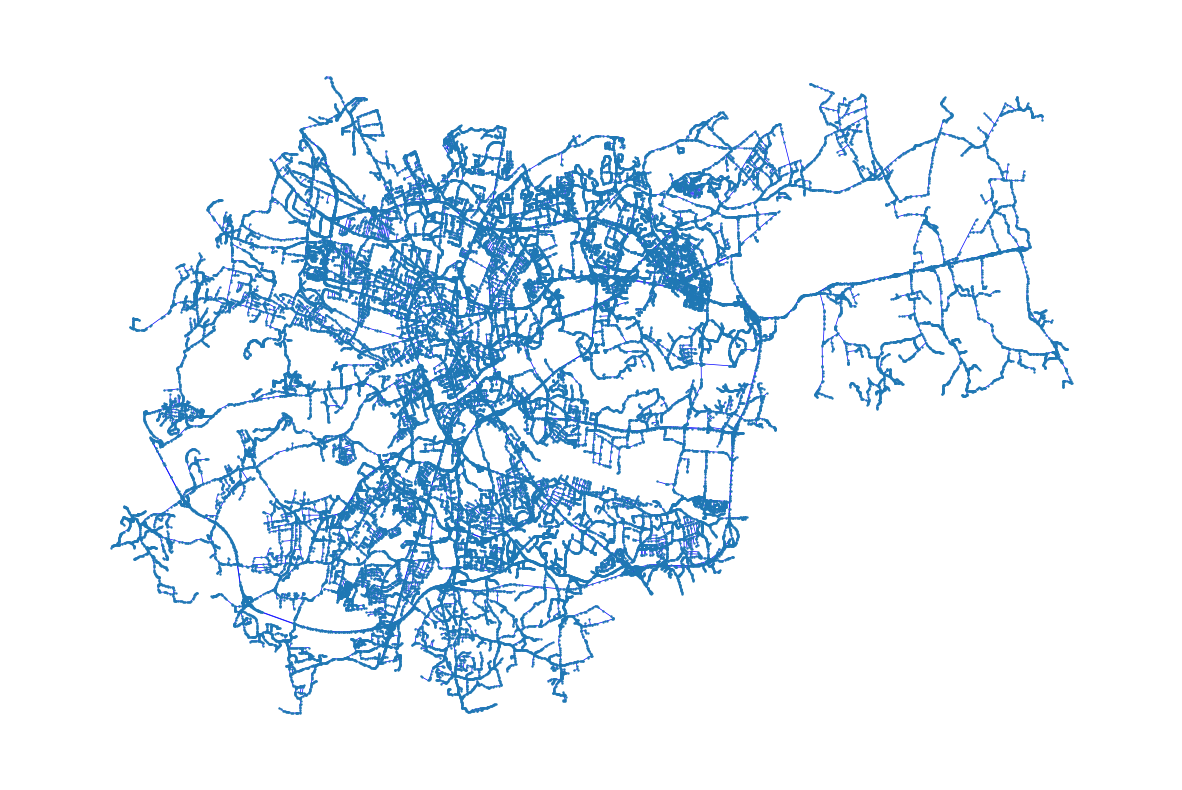

In [10]:
#plot graph
fig, ax = plt.subplots(figsize=(15, 10))
nx.draw(G, pos={node: node for node in G.nodes()}, ax=ax, node_size=0.5, edge_color='blue', width=0.5)


In [11]:
#choose 2 random points from nearest_gdf
sampled_points = nearest_gdf.sample(2, random_state=123)
display(sampled_points)


#calculate shortest path between 2 points in graph
distance_in_graph = nx.shortest_path_length(G, source=tuple(sampled_points.iloc[0]['geometry'].coords[0]), target=tuple(sampled_points.iloc[1]['geometry'].coords[0]), weight='weight')
print('Distance in graph:', distance_in_graph, 'm')



#calculate distance in straight line between 2 points
from geopy.distance import geodesic
from shapely.geometry import Point

point1 = Point(sampled_points.iloc[0]['geometry'].x, sampled_points.iloc[0]['geometry'].y)
point2 = Point(sampled_points.iloc[1]['geometry'].x, sampled_points.iloc[1]['geometry'].y)
straight_line_distance = geodesic((point1.y, point1.x), (point2.y, point2.x)).m
print('Straight line distance:', straight_line_distance, 'm')


,id,distance,geometry
59,3250835412,9.799271,POINT (19.95237 50.04682)
245,8354124522,25.589994,POINT (19.95221 50.07177)


Distance in graph: 2962.0871757117948 m
Straight line distance: 2776.0766605765984 m


(19.75345804, 20.25184736, 49.955793164999996, 50.136551435)

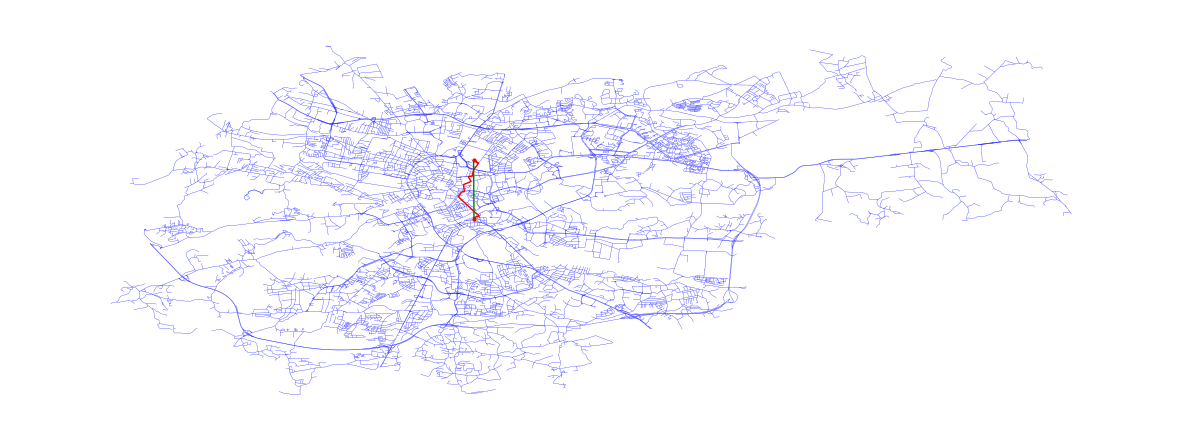

In [12]:
from shapely.geometry import LineString

#plot sampled points and shortest path between them
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(*point1.xy, color='red', marker='o', markersize=2)
plt.plot(*point2.xy, color='red', marker='o', markersize=2)
nx.draw(G, pos={node: node for node in G.nodes()}, ax=ax, node_size=0, edge_color='blue', width=0.2)
shortest_path = nx.shortest_path(G, source=tuple(sampled_points.iloc[0]['geometry'].coords[0]), target=tuple(sampled_points.iloc[1]['geometry'].coords[0]), weight='weight')
shortest_path_line = LineString(shortest_path)
shortest_path_gdf = gpd.GeoDataFrame(geometry=[shortest_path_line])
shortest_path_gdf.plot(ax=ax, color='red', linewidth=1)
straight_line = LineString([point1, point2])
straight_line_gdf = gpd.GeoDataFrame(geometry=[straight_line])
straight_line_gdf.plot(ax=ax, color='green', linewidth=1)

plt.axis('off')

Jak można zauważyć wartość odległości w grafie jest niedoszacowana, dlatego obliczymy ją takim samym sposobem jak wcześniej dla wszystkich krawędzi grafu

In [15]:
#pętla przez wszystkie krawędzie grafu i obliczenie odległości między punktami na nowo
for u, v, data in tqdm.tqdm(G.edges(data=True)):
    point1 = Point(u)
    point2 = Point(v)
    distance = geodesic((point1.y, point1.x), (point2.y, point2.x)).m
    data['weight'] = distance


100%|██████████| 83714/83714 [00:08<00:00, 10011.60it/s]


In [14]:
#choose 2 random points from nearest_gdf
sampled_points = nearest_gdf.sample(2, random_state=123)
display(sampled_points)

#calculate shortest distance between 2 points in graph
distance_in_graph = nx.shortest_path_length(G, source=tuple(sampled_points.iloc[0]['geometry'].coords[0]), target=tuple(sampled_points.iloc[1]['geometry'].coords[0]), weight='weight')
print('Distance in graph:', distance_in_graph, 'm')

#calculate distance in straight line between 2 points
from geopy.distance import geodesic
from shapely.geometry import Point

point1 = Point(sampled_points.iloc[0]['geometry'].x, sampled_points.iloc[0]['geometry'].y)
point2 = Point(sampled_points.iloc[1]['geometry'].x, sampled_points.iloc[1]['geometry'].y)
straight_line_distance = geodesic((point1.y, point1.x), (point2.y, point2.x)).m
print('Straight line distance:', straight_line_distance, 'm')


,id,distance,geometry
211,7086813203,10.584078,POINT (19.94544 50.04281)
54,3090689453,14.422227,POINT (19.89459 50.01771)


Distance in graph: 5350.001895157851 m
Straight line distance: 4590.197629566327 m


In [15]:
def dwie_żaby (id1, id2):
    sampled_points = nearest_gdf[nearest_gdf['id'].isin([id1, id2])]
    point1 = Point(sampled_points.iloc[0]['geometry'].x, sampled_points.iloc[0]['geometry'].y)
    point2 = Point(sampled_points.iloc[1]['geometry'].x, sampled_points.iloc[1]['geometry'].y)
    straight_line_distance = geodesic((point1.y, point1.x), (point2.y, point2.x)).m
    distance_in_graph = nx.shortest_path_length(G, source=tuple(sampled_points.iloc[0]['geometry'].coords[0]), target=tuple(sampled_points.iloc[1]['geometry'].coords[0]), weight='weight')
    print('Distance in graph:', distance_in_graph, 'm')
    print('Straight line distance:', straight_line_distance, 'm')
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.plot(*point1.xy, color='red', marker='o', markersize=2)
    plt.plot(*point2.xy, color='red', marker='o', markersize=2)
    nx.draw(G, pos={node: node for node in G.nodes()}, ax=ax, node_size=0, edge_color='blue', width=0.2)
    shortest_path = nx.shortest_path(G, source=tuple(sampled_points.iloc[0]['geometry'].coords[0]), target=tuple(sampled_points.iloc[1]['geometry'].coords[0]), weight='weight')
    shortest_path_line = LineString(shortest_path)
    shortest_path_gdf = gpd.GeoDataFrame(geometry=[shortest_path_line])
    shortest_path_gdf.plot(ax=ax, color='red', linewidth=1)
    straight_line = LineString([point1, point2])
    straight_line_gdf = gpd.GeoDataFrame(geometry=[straight_line])
    straight_line_gdf.plot(ax=ax, color='green', linewidth=1)
    plt.axis('off')
    return distance_in_graph, straight_line_distance

def dwie_żaby_html (id1, id2):
    sampled_points = nearest_gdf[nearest_gdf['id'].isin([id1, id2])]
    point1 = Point(sampled_points.iloc[0]['geometry'].x, sampled_points.iloc[0]['geometry'].y)
    point2 = Point(sampled_points.iloc[1]['geometry'].x, sampled_points.iloc[1]['geometry'].y)
    straight_line_distance = geodesic((point1.y, point1.x), (point2.y, point2.x)).m
    distance_in_graph = nx.shortest_path_length(G, source=tuple(sampled_points.iloc[0]['geometry'].coords[0]), target=tuple(sampled_points.iloc[1]['geometry'].coords[0]), weight='weight')
    print('Distance in graph:', distance_in_graph, 'm')
    print('Straight line distance:', straight_line_distance, 'm')
    import folium
    m = folium.Map(location=[50.06465, 19.94498], zoom_start=13)
    folium.Marker([point1.y, point1.x], popup='Start').add_to(m)
    folium.Marker([point2.y, point2.x], popup='End').add_to(m)
    folium.PolyLine([(point1.y, point1.x), (point2.y, point2.x)], color='green').add_to(m)
    shortest_path = nx.shortest_path(G, source=tuple(sampled_points.iloc[0]['geometry'].coords[0]), target=tuple(sampled_points.iloc[1]['geometry'].coords[0]), weight='weight')
    for i in range(len(shortest_path) - 1):
        folium.PolyLine([(shortest_path[i][1], shortest_path[i][0]), (shortest_path[i + 1][1], shortest_path[i + 1][0])], color='red').add_to(m)
    #add exact points of Żabka to plot
    zaba1 = zabki_gdf[zabki_gdf['id'] == id1]
    zaba2 = zabki_gdf[zabki_gdf['id'] == id2]
    folium.Marker([zaba1.iloc[0]['geometry'].y, zaba1.iloc[0]['geometry'].x], popup='Żabka 1 <br> ID: ' + str(id1) + '<br> Graph distance: ' + str(round(distance_in_graph,2)) + 'm <br> Straight line distance: ' + str(round(straight_line_distance,2)) + 'm').add_to(m)
    folium.Marker([zaba2.iloc[0]['geometry'].y, zaba2.iloc[0]['geometry'].x], popup='Żabka 2 <br> ID: ' + str(id2) + '<br> Graph distance: ' + str(round(distance_in_graph,2)) + 'm <br> Straight line distance: ' + str(round(straight_line_distance,2)) + 'm').add_to(m)

    import webbrowser
    m.save('map.html')
    webbrowser.open('map.html')
    return distance_in_graph, straight_line_distance



Tutaj można ręcznie wpisać id 2 żabek korzystając z wcześniejszej mapy i otworzy się mapa z trasą i odległością w linii prostej.

In [16]:
#draw 2 random żabka ids
import random
id1 = zabki_gdf['id'].sample(1).values[0]
id2 = zabki_gdf['id'].sample(1).values[0]
print(id1, id2)
dwie_żaby_html(id1, id2)

9522092316 11242237732
Distance in graph: 5124.660366641937 m
Straight line distance: 4340.654686246186 m


(5124.660366641937, 4340.654686246186)

# Tworzenie macierzy ścieżek i odległości

Proces tworzenia macierzy ścieżek trwa kilka godziń, dlatego poniższa komórka zapisuje i automatycznie wczytuje dane co 10 iteracji, aby nie stracić danych oraz móc podzielić obliczenia.

In [17]:
#create matrix of shortest paths between all points
path_matrix = np.zeros((neares_gdf.shape[0], neares_gdf.shape[0]), dtype='object')
#try load matrix from file
try:
    path_matrix = np.load('path_matrix.npy', allow_pickle=True)
except:
    pass

def reverse_path(path):
    return path[::-1]

for i in tqdm.tqdm(range(neares_gdf.shape[0])):
    for j in range(neares_gdf.shape[0]):
        if i == j:
            path_matrix[i, j] = 0
        if i >= j:
            continue
        if path_matrix[i, j] != 0:
            continue # path already calculated
        
        path_matrix[i, j] = nx.shortest_path(G, source=tuple(neares_gdf.iloc[i]['geometry'].coords[0]), target=tuple(neares_gdf.iloc[j]['geometry'].coords[0]), weight='weight')
        path_matrix[j, i] = reverse_path(path_matrix[i, j])
    if i % 10 == 0:
        np.save('path_matrix.npy', path_matrix)
np.save('path_matrix.npy', path_matrix)



100%|██████████| 372/372 [41:42<00:00,  6.73s/it]


In [19]:
path_matrix_df = pd.DataFrame(path_matrix, index=neares_gdf['id'], columns=neares_gdf['id'])
path_matrix_df.head()

id,488395425,490986192,968080349,974197831,1238620983,1241313693,1319234289,1502425598,1680840225,1691818892,...,11570652162,11589822277,11612210728,11618059969,11618151973,11695043417,11767392324,11775178769,11787336869,11813414890
id,,,,,,,,,,,,,,,,,,,,,
488395425,0,"[(19.9090584, 50.0161726), (19.9088806, 50.016...","[(19.9090584, 50.0161726), (19.9088806, 50.016...","[(19.9090584, 50.0161726), (19.9088806, 50.016...","[(19.9090584, 50.0161726), (19.9088806, 50.016...","[(19.9090584, 50.0161726), (19.9088806, 50.016...","[(19.9090584, 50.0161726), (19.9088806, 50.016...","[(19.9090584, 50.0161726), (19.9088806, 50.016...","[(19.9090584, 50.0161726), (19.9088806, 50.016...","[(19.9090584, 50.0161726), (19.9088806, 50.016...",...,"[(19.9090584, 50.0161726), (19.9088806, 50.016...","[(19.9090584, 50.0161726), (19.9088806, 50.016...","[(19.9090584, 50.0161726), (19.9088806, 50.016...","[(19.9090584, 50.0161726), (19.9088806, 50.016...","[(19.9090584, 50.0161726), (19.9088806, 50.016...","[(19.9090584, 50.0161726), (19.9088806, 50.016...","[(19.9090584, 50.0161726), (19.9088806, 50.016...","[(19.9090584, 50.0161726), (19.9088806, 50.016...","[(19.9090584, 50.0161726), (19.9088806, 50.016...","[(19.9090584, 50.0161726), (19.9088806, 50.016..."
490986192,"[(19.9387072, 50.0653243), (19.9382898, 50.065...",0,"[(19.9387072, 50.0653243), (19.9388433, 50.065...","[(19.9387072, 50.0653243), (19.9388433, 50.065...","[(19.9387072, 50.0653243), (19.9388433, 50.065...","[(19.9387072, 50.0653243), (19.9382898, 50.065...","[(19.9387072, 50.0653243), (19.9382898, 50.065...","[(19.9387072, 50.0653243), (19.9388433, 50.065...","[(19.9387072, 50.0653243), (19.9388433, 50.065...","[(19.9387072, 50.0653243), (19.9388433, 50.065...",...,"[(19.9387072, 50.0653243), (19.9382898, 50.065...","[(19.9387072, 50.0653243), (19.9388433, 50.065...","[(19.9387072, 50.0653243), (19.9388433, 50.065...","[(19.9387072, 50.0653243), (19.9389825, 50.065...","[(19.9387072, 50.0653243), (19.9389825, 50.065...","[(19.9387072, 50.0653243), (19.9388433, 50.065...","[(19.9387072, 50.0653243), (19.9389825, 50.065...","[(19.9387072, 50.0653243), (19.9382898, 50.065...","[(19.9387072, 50.0653243), (19.9388433, 50.065...","[(19.9387072, 50.0653243), (19.9388433, 50.065..."
968080349,"[(20.0479064, 50.074485), (20.0475963, 50.0744...","[(20.0479064, 50.074485), (20.0475963, 50.0744...",0,"[(20.0479064, 50.074485), (20.0475963, 50.0744...","[(20.0479064, 50.074485), (20.0475963, 50.0744...","[(20.0479064, 50.074485), (20.0475963, 50.0744...","[(20.0479064, 50.074485), (20.0475963, 50.0744...","[(20.0479064, 50.074485), (20.0475963, 50.0744...","[(20.0479064, 50.074485), (20.0475963, 50.0744...","[(20.0479064, 50.074485), (20.0475963, 50.0744...",...,"[(20.0479064, 50.074485), (20.0475963, 50.0744...","[(20.0479064, 50.074485), (20.0475963, 50.0744...","[(20.0479064, 50.074485), (20.0475963, 50.0744...","[(20.0479064, 50.074485), (20.0475963, 50.0744...","[(20.0479064, 50.074485), (20.0475963, 50.0744...","[(20.0479064, 50.074485), (20.0475963, 50.0744...","[(20.0479064, 50.074485), (20.0475963, 50.0744...","[(20.0479064, 50.074485), (20.0475963, 50.0744...","[(20.0479064, 50.074485), (20.0475963, 50.0744...","[(20.0479064, 50.074485), (20.0475963, 50.0744..."
974197831,"[(19.914764, 50.0716622), (19.9145619, 50.0713...","[(19.914764, 50.0716622), (19.9145619, 50.0713...","[(19.914764, 50.0716622), (19.9151361, 50.0722...",0,"[(19.914764, 50.0716622), (19.9151361, 50.0722...","[(19.914764, 50.0716622), (19.9145619, 50.0713...","[(19.914764, 50.0716622), (19.9145619, 50.0713...","[(19.914764, 50.0716622), (19.9151361, 50.0722...","[(19.914764, 50.0716622), (19.9151361, 50.0722...","[(19.914764, 50.0716622), (19.9151361, 50.0722...",...,"[(19.914764, 50.0716622), (19.9145619, 50.0713...","[(19.914764, 50.0716622), (19.9145619, 50.0713...","[(19.914764, 50.0716622), (19.9151361, 50.0722...","[(19.914764, 50.0716622), (19.9145619, 50.0713...","[(19.914764, 50.0716622), (19.9145619,

In [63]:
# naprawienie błędów w path_matrix_df - zamiana listy punktów na LineString
# Powodowane przez zapisywanie i wczytywanie do pliku w trakcie obliczeń

for i in tqdm.tqdm(range(path_matrix_df.shape[0])):
    for j in range(path_matrix_df.shape[1]):
        if path_matrix_df.iloc[i, j] != 0:
            if not isinstance(path_matrix_df.iloc[i, j], LineString):
                list_of_points = []
                if isinstance(path_matrix_df.iloc[i, j], Point):
                    list_of_points.append(path_matrix_df.iloc[i, j])
                else:
                    for point in path_matrix_df.iloc[i, j]:
                        list_of_points.append(Point(point))
                if len(list_of_points) > 1:
                    path_matrix_df.iloc[i, j] = LineString(list_of_points)

100%|██████████| 372/372 [06:12<00:00,  1.00s/it]


In [64]:
path_matrix_df.to_pickle('path_matrix_df.pkl')

In [67]:
path_matrix_df = pd.read_pickle('path_matrix_df.pkl')
#check if all values are LineString
for i in range(path_matrix_df.shape[0]):
    for j in range(path_matrix_df.shape[1]):
        if path_matrix_df.iloc[i, j] != 0:
            if not isinstance(path_matrix_df.iloc[i, j], LineString):
                print(i, j)
                print(path_matrix_df.iloc[i, j])
                break
            


40 220
[(19.9602972, 50.0882217)]
220 40
[(19.9602972, 50.0882217)]
324 340
[(19.895754, 50.0317215)]
340 324
[(19.895754, 50.0317215)]


In [69]:
#ids of żabka on 40 and 220 position
id1 = neares_gdf.iloc[40]['id']
id2 = neares_gdf.iloc[220]['id']
print(id1, id2)
dwie_żaby_html(id1, id2)

2598904066 7580485757
Distance in graph: 0 m
Straight line distance: 0.0 m


(0, 0.0)

In [70]:
#ids of żabka on 324 and 340 position
id1 = neares_gdf.iloc[324]['id']
id2 = neares_gdf.iloc[340]['id']
print(id1, id2)
dwie_żaby_html(id1, id2)

10699842909 11065191665
Distance in graph: 0 m
Straight line distance: 0.0 m


(0, 0.0)

Są to zduplikowane żabki na praktycznie tych samych miejscach, błąd w danych, który nie został wcześniej wykryty

In [71]:
# usuńmy po 1 zduplikowanym sklepie.
# pierwsza para żabek
id1 = neares_gdf.iloc[40]['id']
id2 = neares_gdf.iloc[220]['id']
id_to_remove = min(id1, id2)
neares_gdf = neares_gdf[neares_gdf['id'] != id_to_remove]
neares_gdf.reset_index(drop=True, inplace=True)
zabki_gdf = zabki_gdf[zabki_gdf['id'] != id_to_remove]
zabki_gdf.reset_index(drop=True, inplace=True)
path_matrix_df.drop(columns=id_to_remove, index=id_to_remove, inplace=True)
# druga para żabek
id1 = neares_gdf.iloc[324]['id']
id2 = neares_gdf.iloc[340]['id']
id_to_remove = min(id1, id2)
neares_gdf = neares_gdf[neares_gdf['id'] != id_to_remove]
neares_gdf.reset_index(drop=True, inplace=True)
zabki_gdf = zabki_gdf[zabki_gdf['id'] != id_to_remove]
zabki_gdf.reset_index(drop=True, inplace=True)
path_matrix_df.drop(columns=id_to_remove, index=id_to_remove, inplace=True)

# nie ma potrzeby ponownie obliczać macierzy odległości, ponieważ graf to wierzchołki ulic, a nie sklepy
# zapiszmy zmiany
neares_gdf.to_file('nearest.geojson', driver='GeoJSON')
path_matrix_df.to_pickle('path_matrix_df.pkl')
zabki_gdf.to_file('zabki_krakow.geojson', driver='GeoJSON')


In [73]:
path_matrix_df = pd.read_pickle('path_matrix_df.pkl')
#check if all values are LineString
for i in range(path_matrix_df.shape[0]):
    for j in range(path_matrix_df.shape[1]):
        if path_matrix_df.iloc[i, j] != 0:
            if not isinstance(path_matrix_df.iloc[i, j], LineString):
                print(i, j)
                print(path_matrix_df.iloc[i, j])
                break



323 338
[(19.895754, 50.0317215)]
338 323
[(19.895754, 50.0317215)]


In [74]:
#ponownie ta sama sytuacja
id1 = neares_gdf.iloc[323]['id']
id2 = neares_gdf.iloc[338]['id']
id_to_remove = min(id1, id2)
neares_gdf = neares_gdf[neares_gdf['id'] != id_to_remove]
neares_gdf.reset_index(drop=True, inplace=True)
zabki_gdf = zabki_gdf[zabki_gdf['id'] != id_to_remove]
zabki_gdf.reset_index(drop=True, inplace=True)
path_matrix_df.drop(columns=id_to_remove, index=id_to_remove, inplace=True)
# zapis zmian
neares_gdf.to_file('nearest.geojson', driver='GeoJSON')
path_matrix_df.to_pickle('path_matrix_df.pkl')
zabki_gdf.to_file('zabki_krakow.geojson', driver='GeoJSON')

In [20]:
path_matrix_df = pd.read_pickle('path_matrix_df.pkl')
#check if all values are LineString
for i in range(path_matrix_df.shape[0]):
    for j in range(path_matrix_df.shape[1]):
        if path_matrix_df.iloc[i, j] != 0:
            if not isinstance(path_matrix_df.iloc[i, j], LineString):
                print(i, j)
                print(path_matrix_df.iloc[i, j])
                break


Teraz udało się uzyskać w pełni poprawne dane, możemy obliczyć macierze dystansów

In [76]:
#distance matrix
distance_matrix = np.zeros((neares_gdf.shape[0], neares_gdf.shape[0]))
for i in tqdm.tqdm(range(neares_gdf.shape[0])):
    for j in range(neares_gdf.shape[0]):
        if i == j:
            distance_matrix[i, j] = 0
        if i >= j:
            continue
        path = path_matrix_df.loc[neares_gdf.iloc[i]['id'], neares_gdf.iloc[j]['id']]
        distance = 0
        for k in range(len(path.coords) - 1):
            distance += G[path.coords[k]][path.coords[k + 1]]['weight']
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance
distance_matrix_df = pd.DataFrame(distance_matrix, index=neares_gdf['id'], columns=neares_gdf['id'])


100%|██████████| 369/369 [04:56<00:00,  1.24it/s]


In [77]:
distance_matrix_df.head()

id,488395425,490986192,968080349,974197831,1238620983,1241313693,1319234289,1502425598,1680840225,1691818892,...,11570652162,11589822277,11612210728,11618059969,11618151973,11695043417,11767392324,11775178769,11787336869,11813414890
id,,,,,,,,,,,,,,,,,,,,,
488395425,0.000000,7226.657188,13934.247168,7823.302506,9407.020889,1517.504425,3220.769098,11597.881999,9704.444014,9433.424260,...,2531.472488,8055.631521,14621.559637,7909.182796,7783.851682,8106.922765,6942.977100,10039.579272,12304.302957,10452.537709
490986192,7226.657188,0.000000,8459.685884,2329.056243,2871.593984,7144.201683,5334.488403,5669.795681,3279.614804,3677.645985,...,8175.126774,2561.385257,8151.764638,5013.438981,4888.107867,1692.211890,889.733100,10657.731907,6207.504100,3508.200871
968080349,13934.247168,8459.685884,0.000000,10541.090948,10146.528542,13851.791662,11322.718500,3024.996740,10490.286092,11867.309669,...,14882.716753,10802.472262,4362.455819,6767.622865,7179.595423,9658.872259,8047.414054,18352.702551,4029.619564,7232.286355
974197831,7823.302506,2329.056243,10541.090948,0.000000,2541.044078,7740.847001,5931.133721,7772.443223,1992.217709,1657.428640,...,8771.772092,338.187156,9308.706668,7091.393028,6966.061914,1533.713988,2967.687147,10801.677414,8281.229865,4665.142901
1238620983,9407.020889,2871.593984,10146.528542,2541.044078,0.000000,9324.565384,7514.852104,7736.540936,1311.160023,2867.902588,...,10355.490475,2879.231234,8079.035298,7568.516154,7645.320284,1340.036856,3738.845371,12800.644362,8234.221777,3613.081824


In [ ]:
#teraz możemy dodać jeszcze odległości w linii prostej między punktem na ulicy a dokładną lokalizacją żabki
# musimy raz przejść przez wszystkie kolumny i raz przez wszystkie wiersze aby dodać wartość neares_gdf['distance']
for i in tqdm.tqdm(range(neares_gdf.shape[0])):
    for j in range(neares_gdf.shape[0]):
        if i == j:
            continue
        distance_matrix_df.iloc[i, j] += 2*(neares_gdf.iloc[j]['distance'] + neares_gdf.iloc[i]['distance'])
distance_matrix_df.head()

In [78]:
distance_matrix_df.to_csv('distance_matrix.csv')

In [26]:
distance_matrix_df = pd.read_csv('distance_matrix.csv', index_col=0)
distance_matrix_df.head()

,488395425,490986192,968080349,974197831,1238620983,1241313693,1319234289,1502425598,1680840225,1691818892,...,11570652162,11589822277,11612210728,11618059969,11618151973,11695043417,11767392324,11775178769,11787336869,11813414890
id,,,,,,,,,,,,,,,,,,,,,
488395425,0.000000,7285.075980,14014.768647,7917.669800,9647.598680,1572.403249,3295.492109,11681.458011,9768.818826,9485.592520,...,2687.543754,8139.380905,14729.249042,7985.175453,7843.468166,8169.535608,7000.299829,10180.443025,12375.777534,10557.209636
490986192,7285.075980,0.000000,8530.285795,2413.501968,3102.250205,7189.178938,5399.289845,5743.450123,3334.068047,3719.892676,...,8321.276470,2635.213073,8249.532474,5079.510069,4937.802782,1744.903164,937.134260,10788.674090,6269.057107,3602.951228
968080349,14014.768647,8530.285795,0.000000,10647.639360,10399.287452,13918.871605,11409.622630,3120.753869,10566.842022,11931.659047,...,15050.969137,10898.402765,4482.326342,6855.796641,7251.393025,9733.666220,8116.917902,18505.747421,4113.275259,7349.139399
974197831,7917.669800,2413.501968,10647.639360,0.000000,2807.648802,7821.772758,6031.883665,7882.046167,2082.619454,1735.623833,...,8953.870290,447.963473,9442.423006,7193.412618,7051.705330,1622.353764,3051.036809,10968.568099,8378.731375,4795.841760
1238620983,9647.598680,3102.250205,10399.287452,2807.648802,0.000000,9551.701637,7761.812544,7992.354377,1547.772264,3092.308278,...,10683.799170,3135.218048,8358.962132,7816.746240,7877.174198,1574.887129,3968.405530,13113.745544,8477.933783,3889.991179


In [79]:
# Dodatkowo obliczmy macierz odległości w linii prostej
distance_matrix_straight_line = np.zeros((neares_gdf.shape[0], neares_gdf.shape[0]))
for i in tqdm.tqdm(range(neares_gdf.shape[0])):
    for j in range(neares_gdf.shape[0]):
        if i == j:
            distance_matrix_straight_line[i, j] = 0
        if i >= j:
            continue
        point1 = Point(neares_gdf.iloc[i]['geometry'].x, neares_gdf.iloc[i]['geometry'].y)
        point2 = Point(neares_gdf.iloc[j]['geometry'].x, neares_gdf.iloc[j]['geometry'].y)
        distance_matrix_straight_line[i, j] = geodesic((point1.y, point1.x), (point2.y, point2.x)).m
        distance_matrix_straight_line[j, i] = distance_matrix_straight_line[i, j]
distance_matrix_straight_line_df = pd.DataFrame(distance_matrix_straight_line, index=neares_gdf['id'], columns=neares_gdf['id'])
distance_matrix_straight_line_df.head()


100%|██████████| 369/369 [00:14<00:00, 25.38it/s] 


id,488395425,490986192,968080349,974197831,1238620983,1241313693,1319234289,1502425598,1680840225,1691818892,...,11570652162,11589822277,11612210728,11618059969,11618151973,11695043417,11767392324,11775178769,11787336869,11813414890
id,,,,,,,,,,,,,,,,,,,,,
488395425,0.000000,5865.194803,11873.549521,6185.619568,7923.748963,870.068517,1953.697024,9566.944215,7964.552902,7030.207145,...,1690.452034,6171.296079,11642.122776,6260.358499,5977.142698,6838.780560,5644.081843,6718.330568,10033.737142,8429.226173
490986192,5865.194803,0.000000,7883.884272,1853.486216,2497.367567,5834.413308,4205.023356,5117.428174,2938.409223,3320.220299,...,6758.654015,2133.043585,6262.047532,3896.266208,3802.890589,1491.533196,690.253529,9168.542777,5228.244986,2652.730827
968080349,11873.549521,7883.884272,0.000000,9536.437235,8757.640925,12323.145385,9950.278280,2778.314612,9506.505228,10782.898001,...,13373.957681,9835.922416,3847.482496,5618.946326,5902.544219,8639.268928,7465.026035,16921.055913,2913.332746,6229.456537
974197831,6185.619568,1853.486216,9536.437235,0.000000,1864.664701,5889.780619,4962.979213,6759.108264,1779.006864,1481.202793,...,6627.270377,299.598602,7399.239904,5722.165049,5607.875841,1045.537796,2510.787836,7943.096209,6745.285272,3647.997456
1238620983,7923.748963,2497.367567,8757.640925,1864.664701,0.000000,7696.670835,6503.258110,6066.469927,748.978075,2275.148819,...,8471.861445,2023.927040,6043.697568,6096.415238,6067.009457,1105.950573,3127.214819,9590.485520,5851.495489,2530.447627


In [80]:
distance_matrix_straight_line_df.to_csv('distance_matrix_straight_line.csv')

Mamy już wszystkie dane jakie potrzebujemy aby rozwiązać problem Komiwojażera dla tych punktów.